In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
import torchaudio
from torchaudio import datasets
import torchtext
from torchaudio.utils import download_asset

import os
import time
from tqdm import tqdm
import IPython.display as ipd

In [ ]:
SAMPLE_WAV_SPEECH_PATH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

In [ ]:
wav, sr = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)

In [ ]:
wav.shape

torch.Size([1, 54400])

In [ ]:
SR = 16000

In [ ]:
import sys

LIB_PATH = '/content/drive/MyDrive/GSC/GSC_helper'
sys.path.append(LIB_PATH)
from GSC12 import SpeechCommands12
from GSC_preprocessing import Preprocessing

# log Mel

In [ ]:
train_dataset = SpeechCommands12('/content/GSC_12', download = True, subset = 'training')
x, y = train_dataset[1]
print(x.shape, y)

>> Downloading speech_commands_v0.02.tar.gz


100%|██████████| 2.26G/2.26G [00:21<00:00, 113MB/s]


torch.Size([1, 16000]) 9


In [ ]:
val_dataset = SpeechCommands12('/content/GSC_12', download = False, subset = 'validation')
test_dataset = SpeechCommands12('/content/GSC_12_test', download = True, subset = 'official_testing')
x_val, y_val = val_dataset[1]
x_test, y_test = test_dataset[1]

>> Downloading speech_commands_test_set_v0.02.tar.gz


100%|██████████| 107M/107M [00:00<00:00, 135MB/s] 


In [ ]:
for x_, y_ in val_dataset:
    if y_ == 0:
        print('>>Done')
        break

>>Done


In [ ]:
transform = nn.Sequential(torchaudio.transforms.MelSpectrogram(sample_rate = SR,
                                                               n_fft = 512,
                                                               win_length = 480,
                                                               hop_length = 160,
                                                               n_mels = 40),
                          torchaudio.transforms.AmplitudeToDB())

In [ ]:
f_pre = lambda is_train, augment: Preprocessing(noise_dir = '/content/GSC_12/_background_noise_',
                                                noise_prob = 0.8,
                                                snr = [-5, 10],
                                                shift  = [-0.1, 0.1],
                                                is_train = is_train,
                                                augment = augment,
                                                transform = transform
                                                )
train_pre = f_pre(True, True)
val_pre = f_pre(False, True)
test_pre = f_pre(False, False)

## Train Augmentation

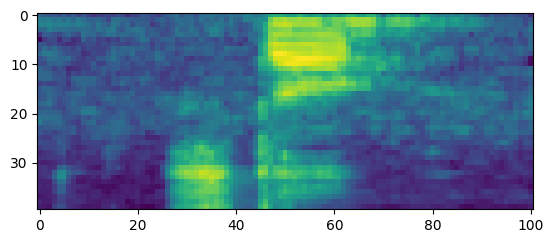

In [ ]:
t1 = transform(x)
t2 = train_pre(x, y)
plt.imshow(t1.squeeze())

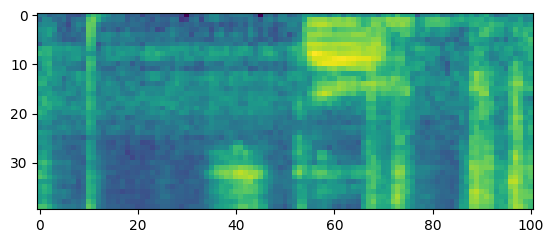

In [ ]:
plt.imshow(t2.squeeze())

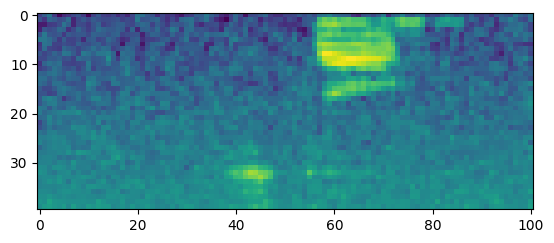

In [ ]:
plt.imshow(t2.squeeze())

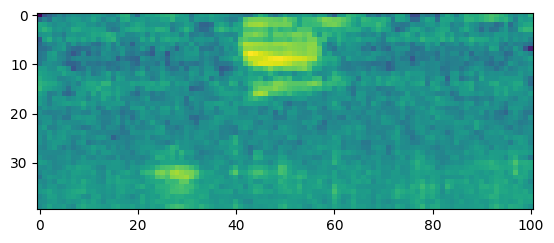

In [ ]:
plt.imshow(t2.squeeze())

## Val Augmentation

In [ ]:
y_val

1

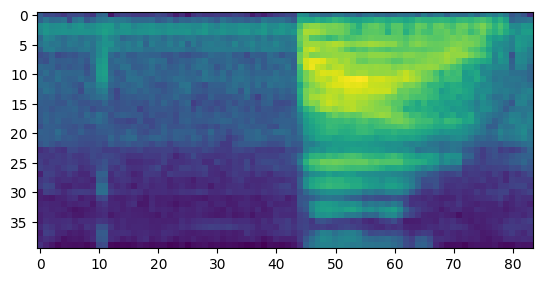

In [ ]:
t1 = transform(x_val)
t2 = val_pre(x_val, '_unknown_')
plt.imshow(t1.squeeze())

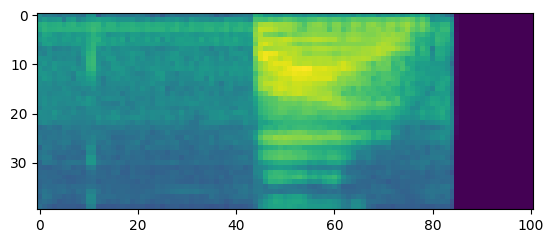

In [ ]:
plt.imshow(t2.squeeze())

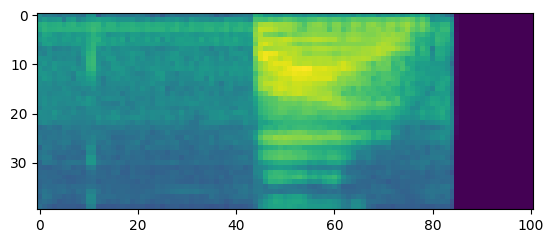

In [ ]:
plt.imshow(t2.squeeze())

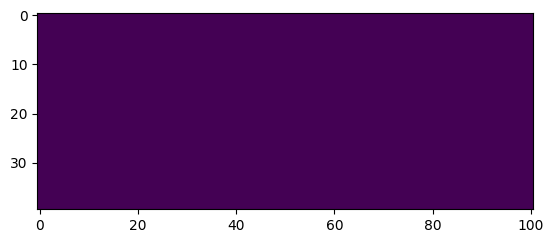

In [ ]:
t1 = transform(x_)
t2 = val_pre(x_, '_silence_')
plt.imshow(t1.squeeze())

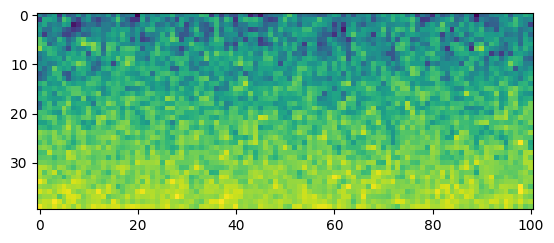

In [ ]:
plt.imshow(t2.squeeze())

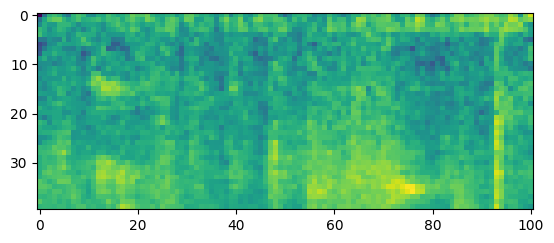

In [ ]:
plt.imshow(t2.squeeze())

## Test Augmentation

## Preprocessing

In [ ]:
train_dataset = SpeechCommands12('/content/GSC_12',
                                 download = False,
                                 subset = 'training',
                                 transform = train_pre)
val_dataset = SpeechCommands12('/content/GSC_12',
                               download = False,
                               subset = 'validation',
                               transform = val_pre)
test_dataset = SpeechCommands12('/content/GSC_12_test',
                                download = False,
                                subset = 'official_testing',
                                transform = test_pre)

In [ ]:
from tqdm import tqdm

def GSC_preprocessing(dataset, output_directory, num_classes = 12, mul_factor = 1, set = 'train', csv_file_name = 'analysised_spec.csv'):
    """
    Preprocessing for each dataset

    mul_factor: increasing the number of data samples by mul_factor times.
    """
    out_df = {
        'link': [],
        'label': [],
    }
    if not os.path.exists(output_directory):
        os.mkdir(output_directory)

    for idx in range(mul_factor):
        # def f(ix, ex):
        for ix, (wav, label) in tqdm(enumerate(dataset)):
            #if ix%1000 == 0:
            #    print(f'{ix}/{len(data_df)}')
            #row = data_df.iloc[ix]
            #label = row['label']

            fname = f'{set}_{label}_{ix}_{idx}.npz'
            #row = {
            #    'link': os.path.join(output_directory, f'label_{label}', fname),
            #    'label': label,
            #    'set': set
            #}
            out_df['link'].append(os.path.join(set, fname))
            out_df['label'].append(label)

            if os.path.exists(os.path.join(output_directory, fname)):
                continue

            #out_df = out_df._append(row, ignore_index = True)
            np.savez_compressed(os.path.join(output_directory, fname), wav.squeeze(0).numpy())

        # Parallel(n_jobs = os.cpu_count())(delayed(f)(i, ex) for i, ex in tqdm(enumerate(dataset)))

    out_df = pd.DataFrame(out_df)
    out_df.to_csv(csv_file_name, index = False)

In [ ]:
GSC_preprocessing(train_dataset, 'train_3', set = 'train', csv_file_name = '/content/train_bc.csv', mul_factor = 4)

In [ ]:
GSC_preprocessing(val_dataset, 'val_3', set = 'val', csv_file_name = '/content/val_bc.csv')

4445it [00:57, 77.04it/s]


In [ ]:
GSC_preprocessing(test_dataset, 'test_3', set = 'test', csv_file_name = '/content/test_bc.csv')

4890it [00:38, 125.85it/s]


In [56]:
GSC_preprocessing(train_dataset, 'train_3', set = 'train', csv_file_name = '/content/train_bc.csv', mul_factor = 4)

36923it [21:47, 28.25it/s]
36923it [21:03, 29.23it/s]
36923it [20:51, 29.49it/s]
36923it [22:06, 27.85it/s]


In [58]:
from utils import zipzip

In [59]:
zipzip('/content/train_3', '/content/drive/MyDrive/GSC12/bcresnet_train.zip')
zipzip('/content/val_3', '/content/drive/MyDrive/GSC12/bcresnet_val.zip')
zipzip('/content/test_3', '/content/drive/MyDrive/GSC12/bcresnet_test.zip')

zipping...: 100%|██████████| 147692/147692 [03:26<00:00, 714.77it/s]


/content/drive/MyDrive/GSC12/bcresnet_train.zip created


zipping...: 100%|██████████| 4445/4445 [00:05<00:00, 854.03it/s] 


/content/drive/MyDrive/GSC12/bcresnet_val.zip created


zipping...: 100%|██████████| 4890/4890 [00:10<00:00, 445.89it/s]


/content/drive/MyDrive/GSC12/bcresnet_test.zip created


In [60]:
import shutil
shutil.move('/content/test_bc.csv', '/content/drive/MyDrive/GSC12')
shutil.move('/content/val_bc.csv', '/content/drive/MyDrive/GSC12')
shutil.move('/content/train_bc.csv', '/content/drive/MyDrive/GSC12')

'/content/drive/MyDrive/GSC12/train_bc.csv'

# Preprocessing

In [ ]:
train_dataset_pt = datasets.SPEECHCOMMANDS('./', 'speech_commands_v0.02', download = True, subset = 'training')
val_dataset_pt = datasets.SPEECHCOMMANDS('./', 'speech_commands_v0.02', download = True, subset = 'validation')
test_dataset_pt = datasets.SPEECHCOMMANDS('./', 'speech_commands_v0.02', download = True, subset = 'testing')

100%|██████████| 2.26G/2.26G [00:32<00:00, 74.1MB/s]


In [ ]:
from torch import Tensor

class LFBE_Delta(nn.Module):
    def __init__(self,
                 sample_rate: int,
                 n_mfcc: int,
                 n_mels: int,
                 melkwargs: dict,
                 ) -> None:
        super().__init__()
        self.mfcc = torchaudio.transforms.MFCC(sample_rate = sample_rate,
                                               n_mfcc = n_mfcc,
                                               melkwargs = melkwargs)
        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate,
                                                        n_mels = n_mels,
                                                        **melkwargs)
        self.todb = torchaudio.transforms.AmplitudeToDB()

    def forward(self, input: Tensor) -> Tensor:
        """
        Args:
        input: Tensor input: (N, C, T)
        """
        logmel = self.todb(self.mel(input))
        mfcc = self.mfcc(input)
        delta = torchaudio.functional.compute_deltas(mfcc)
        delta2 = torchaudio.functional.compute_deltas(delta)
        return torch.concat([logmel, delta, delta2], dim = 1)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (241) may be set too low.
  warnings.warn(


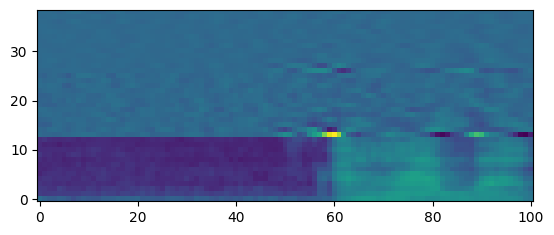

In [ ]:
melkwargs = {
              'n_fft' : 480,
              'hop_length' : 160,
              'f_min' : 20,
              'f_max' : 4000,
}
f_lfbe = LFBE_Delta(sample_rate= 16000,
                    n_mfcc = 13,
                    n_mels = 13,
                    melkwargs = melkwargs)
w_lfbe = f_lfbe(wav[:,:16000])
plt.imshow(w_lfbe.squeeze(), origin = 'lower')

In [ ]:
import random

def pad_truncate(wav, max_length = 16000, pad_value = 0):
    wav_length = len(wav)
    if wav_length < max_length:
        pad = torchtext.transforms.PadTransform(max_length, 0)
        wav = pad(wav)
    return wav

def time_shift(wav, shift, sr = 16000, max_length = 16000):
    """

    shift: float
        Unit: Seconds
    """
    wav = torch.roll(wav, int(shift*sr))
    return wav[:, :max_length]

## Add Noise
def normalzieNoise(wav, noise, max_length = 16000):
    len_wav = wav.shape[1]
    len_noise = noise.shape[1]
    if len_wav > len_noise:
        buf = torch.zeros_like(wav)
        start_point = int((len_wav - len_noise)*random.uniform(0, 1))
        end_point = start_point + len_noise
        buf[:, start_point: end_point] = noise
        noise = buf
    elif len_wav < len_noise:
        start_point = int((len_noise - len_wav)*random.uniform(0, 1))
        end_point = start_point + len_wav
        noise = noise[:, start_point: end_point]
    return noise[:, :max_length]

def randomNoise(noise_directory):
    listnoise = [f for f in os.listdir(noise_directory)
                 if f.endswith('.wav')]
    noise = random.choice(listnoise)
    noise, sr = torchaudio.load(os.path.join(noise_directory, noise))
    return noise

def addNoise(wav, noise):
    noise = normalzieNoise(wav, noise)
    addnsy = torchaudio.transforms.AddNoise()
    return addnsy(wav, noise, snr = torch.Tensor([random.uniform(-5, 10)]))

class AddBGNoise(nn.Module):
    def __init__(self):
        super().__init__()
        self.NOISE_PATH = '/content/SpeechCommands/speech_commands_v0.02/_background_noise_'

    def forward(self, x):
        p = random.uniform(0, 1)
        if p <= 0.8:
            noise = randomNoise(self.NOISE_PATH)
            x = addNoise(x, noise)
        return x

class GSC_TrainAugment(nn.Module):
    def __init__(self, sr):
        super().__init__()
        #self.resample = torchaudio.transforms.Resample(sr, int(sr*random.uniform(0.9, 1.1)))
        #self.time_shift = lambda x: time_shift(x, random.uniform(-0.05, 0.05))
        self.pad_trunc = lambda x: pad_truncate(x, sr)
        self.add_noise = AddBGNoise()
        melkwargs = {
              'n_fft' : 480,
              'hop_length' : 160,
              'f_min' : 20,
              'f_max' : 4000,
        }
        self.lfbe = LFBE_Delta(sample_rate = sr,
                               n_mfcc = 13,
                               n_mels = 13,
                               melkwargs = melkwargs)

    def forward(self, x):
        #x = self.resample(x)
        #x = self.time_shift(x)
        x = self.pad_trunc(x)
        x = self.add_noise(x)
        x = self.lfbe(x)
        return x

class GSC_TestAugment(nn.Module):
    def __init__(self, sr):
        super().__init__()
        self.pad_trunc = lambda x: pad_truncate(x, sr)
        melkwargs = {
              'n_fft' : 480,
              'hop_length' : 160,
              'f_min' : 20,
              'f_max' : 4000,
        }
        self.lfbe = LFBE_Delta(sample_rate = sr,
                               n_mfcc = 13,
                               n_mels = 13,
                               melkwargs = melkwargs)

    def forward(self, x):
        x = self.pad_trunc(x)
        x = self.lfbe(x)
        return x

train_transform = GSC_TrainAugment(16000)
test_transform = GSC_TestAugment(16000)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (241) may be set too low.
  warnings.warn(


In [ ]:
test_transform(wav[:, :16000]).shape

torch.Size([1, 39, 101])

In [ ]:
from GSC import download_GSC

In [ ]:
ZIP_MAP = download_GSC('https://drive.google.com/file/d/1hVXW_zSMNlJXxza_3Ojtgrq16q45dt3k/view?usp=drive_link',
                       'https://drive.google.com/file/d/1-19CGvTGwZopQcT7VA0mxAGwvCjgx-cF/view?usp=drive_link',
                       'https://drive.google.com/file/d/1-CdPCNkYcprSzlqGXgho_wICSjYPS55B/view?usp=drive_link',
                       '/content/tf_mdata',
                       end = '.zip')
CSV_MAP = download_GSC('https://drive.google.com/file/d/1-EZJqm6VLTLkCFefpqBNX25vre9r9HoX/view?usp=drive_link',
                       'https://drive.google.com/file/d/1ZEJLFxuevd44xwFIVfJv2F7S2YHUPz9k/view?usp=drive_link',
                       'https://drive.google.com/file/d/1-1ouA4TZGbwlpemo-1dScGlHCQjTwQDr/view?usp=drive_link',
                       '/content/tf_mdata',
                       end = '.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1hVXW_zSMNlJXxza_3Ojtgrq16q45dt3k
From (redirected): https://drive.google.com/uc?id=1hVXW_zSMNlJXxza_3Ojtgrq16q45dt3k&confirm=t&uuid=d22d4b61-7ce1-4d48-887b-6ef9341de1ce
To: /content/tf_mdata/train.zip
100%|██████████| 1.98G/1.98G [00:18<00:00, 106MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-19CGvTGwZopQcT7VA0mxAGwvCjgx-cF
From (redirected): https://drive.google.com/uc?id=1-19CGvTGwZopQcT7VA0mxAGwvCjgx-cF&confirm=t&uuid=b996b70a-5041-4a49-80a7-3f46a5fa2ccc
To: /content/tf_mdata/val.zip
100%|██████████| 234M/234M [00:01<00:00, 125MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-CdPCNkYcprSzlqGXgho_wICSjYPS55B
From (redirected): https://drive.google.com/uc?id=1-CdPCNkYcprSzlqGXgho_wICSjYPS55B&confirm=t&uuid=3f9451fb-2f79-4398-b708-d20c1f4a22a2
To: /content/tf_mdata/test.zip
100%|██████████| 113M/113M [00:02<00:00, 53.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-E

In [ ]:
def GSC_preprocessing(csv_file, root, output_directory, num_classes = 12, transform = None,
                       mul_factor = 1, set = 'train', csv_file_name = 'analysised_spec.csv'):
    """
    Preprocessing for each dataset

    mul_factor: increasing the number of data samples by mul_factor times.
    """
    out_df = {
        'link': [],
        'label': [],
    }
    data_df = pd.read_csv(csv_file)

    for idx in range(mul_factor):
        # def f(ix, ex):
        for ix in tqdm(range(len(data_df))):
            #if ix%1000 == 0:
            #    print(f'{ix}/{len(data_df)}')
            row = data_df.iloc[ix]
            label = row['label']
            wav = np.load(os.path.join(root, row['link']))['arr_0']

            fname = f'{set}_{label}_{ix}_{idx}.npz'
            #row = {
            #    'link': os.path.join(output_directory, f'label_{label}', fname),
            #    'label': label,
            #    'set': set
            #}
            out_df['link'].append(os.path.join(set, fname))
            out_df['label'].append(label)

            if os.path.exists(os.path.join(output_directory, fname)):
                continue

            wav = torch.from_numpy(wav).unsqueeze(0)

            if transform:
                wav = transform(wav.float())

            #out_df = out_df._append(row, ignore_index = True)
            np.savez_compressed(os.path.join(output_directory, fname), wav.squeeze(0).numpy())

        # Parallel(n_jobs = os.cpu_count())(delayed(f)(i, ex) for i, ex in tqdm(enumerate(dataset)))

    out_df = pd.DataFrame(out_df)
    out_df.to_csv(csv_file_name, index = False)

In [ ]:
from GSC_zip import unzipzip, zipzip

In [ ]:
unzipzip(ZIP_MAP['train'], '/content/train')
unzipzip(ZIP_MAP['val'], '/content/val')
unzipzip(ZIP_MAP['test'], '/content/test')

Extracted /content/tf_mdata/train.zip
Extracted /content/tf_mdata/val.zip
Extracted /content/tf_mdata/test.zip


In [ ]:
GSC_preprocessing(CSV_MAP['val'], '/content', '/content/val_3', transform = test_transform, set = 'val', csv_file_name = '/content/drive/MyDrive/EdgeCRNN_GSC/EdgeCRNN_GSC/val_12_lfbe.csv')

100%|██████████| 10102/10102 [01:48<00:00, 93.25it/s] 


In [ ]:
GSC_preprocessing(CSV_MAP['test'], '/content', '/content/test_3', transform = test_transform, set = 'test', csv_file_name = '/content/drive/MyDrive/EdgeCRNN_GSC/EdgeCRNN_GSC/test_12_lfbe.csv')

100%|██████████| 4890/4890 [00:54<00:00, 89.39it/s]


In [ ]:
zipzip('/content/val_3', '/content/drive/MyDrive/EdgeCRNN_GSC/EdgeCRNN_GSC/val_12_lfbe.zip')
zipzip('/content/test_3', '/content/drive/MyDrive/EdgeCRNN_GSC/EdgeCRNN_GSC/test_12_lfbe.zip')

zipping...: 100%|██████████| 10102/10102 [00:11<00:00, 909.51it/s] 


/content/drive/MyDrive/EdgeCRNN_GSC/EdgeCRNN_GSC/val_12_lfbe.zip created


zipping...: 100%|██████████| 4890/4890 [00:04<00:00, 1028.35it/s]


/content/drive/MyDrive/EdgeCRNN_GSC/EdgeCRNN_GSC/test_12_lfbe.zip created


## Non-Noise

In [ ]:
GSC_preprocessing(CSV_MAP['train'], '/content', '/content/train_3', transform = test_transform, set = 'train', csv_file_name = '/content/drive/MyDrive/EdgeCRNN_GSC/EdgeCRNN_GSC/train_12_lfbe_non.csv')

100%|██████████| 85511/85511 [17:52<00:00, 79.73it/s]


In [ ]:
zipzip('/content/train_3', '/content/drive/MyDrive/EdgeCRNN_GSC/EdgeCRNN_GSC/train_12_lfbe_non.zip')

zipping...: 100%|██████████| 85511/85511 [01:51<00:00, 768.95it/s] 


/content/drive/MyDrive/EdgeCRNN_GSC/EdgeCRNN_GSC/train_12_lfbe_non.zip created


In [ ]:
wav_ = train_transform(wav)

ipd.Audio(wav_, rate = sr)

In [ ]:
resample = torchaudio.transforms.Resample(sr, int(sr*random.uniform(0.9, 1.1)))
wav1 = resample(wav)
resample = torchaudio.transforms.Resample(sr, int(sr*random.uniform(0.9, 1.1)))
wav2 = resample(wav)

In [ ]:
print(wav1.shape)
print(wav2.shape)

torch.Size([1, 54370])
torch.Size([1, 49878])


In [ ]:
wav.shape

torch.Size([1, 54400])

In [ ]:
ipd.Audio(wav, rate = sr)

In [ ]:
ipd.Audio(wav1, rate = sr)

In [ ]:
ipd.Audio(wav2, rate = sr)